In [1]:
# seed our random values for reproducible code

import numpy as np
np.random.seed(0)
import random
random.seed(0)

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
import time
import pandas as pd

In [3]:
def simple_grid_search(x_train, y_train, x_test, y_test, feature_engineering_pipeline):
    ''' 
    simple helper function to grid search an ExtraTreesClassifier model and 
    print out a classification report for the best param set.
    Best here is defined as having the best cross-validated accuracy on the training set
    '''
    
    params = {  # some simple parameters to grid search
        'max_depth': [10, None],
        'n_estimators': [10, 50, 100, 500],
        'criterion': ['gini', 'entropy']
    }

    base_model = ExtraTreesClassifier()

    model_grid_search = GridSearchCV(base_model, param_grid=params, cv=3)
    start_time = time.time()  # capture the start time
    if feature_engineering_pipeline:  # fit FE pipeline to training data and use it to transform test data
        parsed_x_train = feature_engineering_pipeline.fit_transform(x_train, y_train)
        parsed_x_test = feature_engineering_pipeline.transform(x_test)
    else:
        parsed_x_train = x_train
        parsed_x_test = x_test

    parse_time = time.time()
    print(f"Parsing took {(parse_time - start_time):.2f} seconds")

    model_grid_search.fit(parsed_x_train, y_train)
    fit_time = time.time()
    print(f"Training took {(fit_time - start_time):.2f} seconds")

    best_model = model_grid_search.best_estimator_

    print(classification_report(y_true=y_test, y_pred=best_model.predict(parsed_x_test)))
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")
    
    return best_model

In [4]:
def advanced_grid_search(x_train, y_train, x_test, y_test, ml_pipeline, params, cv=3, include_probas=False, is_regression=False):
    ''' 
    This helper function will grid search a machine learning pipeline with feature engineering included
    and print out a classification report for the best param set. 
    Best here is defined as having the best cross-validated accuracy on the training set
    '''
    
    model_grid_search = GridSearchCV(ml_pipeline, param_grid=params, cv=cv, error_score=-1)
    start_time = time.time()  # capture the start time

    model_grid_search.fit(x_train, y_train)

    best_model = model_grid_search.best_estimator_
    
    y_preds = best_model.predict(x_test)
    
    if is_regression:
        rmse = np.sqrt(mean_squared_error(y_pred=y_preds, y_true=test_set['pct_change_eod']))
        print(f'RMSE: {rmse:.5f}')
    else:
        print(classification_report(y_true=y_test, y_pred=y_preds))
    print(f'Best params: {model_grid_search.best_params_}')
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")
    
    if include_probas:
        y_probas = best_model.predict_proba(x_test).max(axis=1)
        return best_model, y_preds, y_probas
    
    return best_model, y_preds

In [5]:
# Exploratory data analysis start !!
# import dataset !!

covid_flu = pd.read_csv('../data/covid_flu.csv')

In [12]:
covid_flu.head()

,Diagnosis,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
0,H1N1,NaN,67.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,38.111111,No
1,H1N1,NaN,29.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H1N1,NaN,22.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H1N1,NaN,20.0,F,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,Yes,Yes,NaN,No,NaN,36.555556,Yes
4,H1N1,NaN,21.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
covid_flu.isnull().mean()

Diagnosis                      0.000000
InitialPCRDiagnosis            0.929825
Age                            0.018893
Sex                            0.051282
neutrophil                     0.930499
serumLevelsOfWhiteBloodCell    0.898111
lymphocytes                    0.894737
CReactiveProteinLevels         0.907557
DurationOfIllness              0.941296
CTscanResults                  0.892713
RiskFactors                    0.858974
GroundGlassOpacity             0.937247
Diarrhea                       0.696356
Fever                          0.377193
Coughing                       0.420378
ShortnessOfBreath              0.949393
SoreThroat                     0.547908
NauseaVomitting                0.715924
Temperature                    0.576248
Fatigue                        0.641700
dtype: float64

In [14]:
covid_flu.shape

(1482, 20)

In [20]:
covid_flu['Diagnosis'].value_counts(normalize=True) # normalize is relative frequencies of each category

Diagnosis
H1N1       0.723347
COVID19    0.276653
Name: proportion, dtype: float64

🐼 What is value_counts()?
- It’s a Series method in Pandas used to count the frequency of unique values in a column (or Series).
- It returns a new Series where:
- The index = unique values
- The values = counts of each unique entry

⚙️ Syntax
Series.value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)

Key Parameters:
- normalize: If True, returns relative frequencies (proportions) instead of counts.
- sort: By default, sorts counts in descending order.
- ascending: If True, sorts in ascending order.
- bins: Groups continuous data into intervals (useful for numerical ranges).
- dropna: If True, excludes NaN values; if False, includes them.


In [21]:
covid_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Diagnosis                    1482 non-null   object 
 1   InitialPCRDiagnosis          104 non-null    object 
 2   Age                          1454 non-null   float64
 3   Sex                          1406 non-null   object 
 4   neutrophil                   103 non-null    float64
 5   serumLevelsOfWhiteBloodCell  151 non-null    float64
 6   lymphocytes                  156 non-null    float64
 7   CReactiveProteinLevels       137 non-null    object 
 8   DurationOfIllness            87 non-null     float64
 9   CTscanResults                159 non-null    object 
 10  RiskFactors                  209 non-null    object 
 11  GroundGlassOpacity           93 non-null     object 
 12  Diarrhea                     450 non-null    object 
 13  Fever             

In [27]:
# extract numerical columns in Pandas 
numeric_types=['float16', 'float32', 'float64', 'int16', 'int32', 'int64'] # the numeric types in Pandas
numerical_columns=covid_flu.select_dtypes(include=numeric_types).columns.tolist()

select_dtypes() in Pandas is used to filter columns of a DataFrame based on their data types.

🐼 Syntax
DataFrame.select_dtypes(include=None, exclude=None)

- include: Data types you want to keep (e.g., ['int64', 'float64']).
- exclude: Data types you want to drop (e.g., ['object']).
- At least one of include or exclude must be provided.

In [28]:
numerical_columns

['Age',
 'neutrophil',
 'serumLevelsOfWhiteBloodCell',
 'lymphocytes',
 'DurationOfIllness',
 'Temperature']

In [29]:
from sklearn.impute import SimpleImputer

In [33]:
# MEAN/MEDIAN IMPUTATION

num_impute=SimpleImputer(strategy='mean')
print(covid_flu['lymphocytes'].head())
print(f"\nMean of Lymphocytes column is {covid_flu['lymphocytes'].mean()}\n")
print(num_impute.fit_transform(covid_flu[['lymphocytes']])[:5])

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: lymphocytes, dtype: float64

Mean of Lymphocytes column is 1.8501538461538463

[[1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]]


In [42]:
# ARBITRARY VALUE IMPULATION

arbitrary_impute=SimpleImputer(strategy='constant', fill_value=999)
arbitrary_impute.fit_transform(covid_flu[numerical_columns])

array([[ 67.        , 999.        , 999.        , 999.        ,
        999.        ,  38.11111111],
       [ 29.        , 999.        , 999.        , 999.        ,
        999.        , 999.        ],
       [ 22.        , 999.        , 999.        , 999.        ,
        999.        , 999.        ],
       ...,
       [  3.        , 999.        ,  15.        , 999.        ,
        999.        , 999.        ],
       [  4.        , 999.        ,   6.6       , 999.        ,
        999.        , 999.        ],
       [  6.        , 999.        ,   5.3       , 999.        ,
        999.        , 999.        ]], shape=(1482, 6))

<Axes: title={'center': 'Lymphocytes'}, xlabel='cells/uL', ylabel='Frequency'>

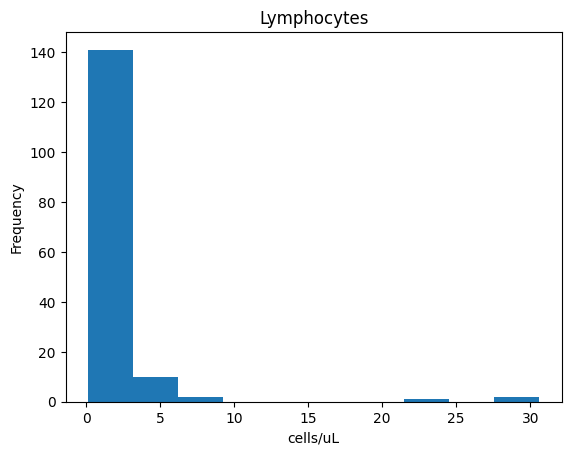

In [44]:
covid_flu['lymphocytes'].plot(title="Lymphocytes", kind='hist', xlabel='cells/uL')

In [49]:
# Extract non-Numerical columns (Categorical Columns)

categorical_types=['O']
categorical_columns=covid_flu.select_dtypes(include=categorical_types).columns.tolist()

In [52]:
categorical_columns

['Diagnosis',
 'InitialPCRDiagnosis',
 'Sex',
 'CReactiveProteinLevels',
 'CTscanResults',
 'RiskFactors',
 'GroundGlassOpacity',
 'Diarrhea',
 'Fever',
 'Coughing',
 'ShortnessOfBreath',
 'SoreThroat',
 'NauseaVomitting',
 'Fatigue']

In [53]:
for each_column in categorical_columns:
    print('==========')
    print(each_column)
    print('==========')
    print(covid_flu[each_column].value_counts(dropna=False))`

Diagnosis
Diagnosis
H1N1       1072
COVID19     410
Name: count, dtype: int64
InitialPCRDiagnosis
InitialPCRDiagnosis
NaN    1378
Yes     100
No        4
Name: count, dtype: int64
Sex
Sex
M      748
F      658
NaN     76
Name: count, dtype: int64
CReactiveProteinLevels
CReactiveProteinLevels
NaN     1345
0.5        3
15         3
8          3
111        2
        ... 
33.2       1
85         1
28.4       1
0.7        1
0.6        1
Name: count, Length: 121, dtype: int64
CTscanResults
CTscanResults
NaN    1323
Yes     144
No       15
Name: count, dtype: int64
RiskFactors
RiskFactors
NaN                                      1273
asthma                                     36
immuno                                     21
pneumonia                                  21
diabetes                                   16
                                         ... 
chronic obstructive pulmonary disease       1
coronary artery disease                     1
Hypertension                               

In [57]:
covid_flu['Sex']=='F'

0        True
1       False
2        True
3        True
4       False
        ...  
1477    False
1478    False
1479    False
1480    False
1481    False
Name: Sex, Length: 1482, dtype: bool

In [60]:
covid_flu['Coughing'].head()

0    Yes
1    NaN
2    NaN
3    Yes
4    NaN
Name: Coughing, dtype: object

In [61]:
cat_impute=SimpleImputer(strategy='most_frequent')
print(cat_impute.fit_transform(covid_flu[['Coughing']])[:5])

[['Yes']
 ['Yes']
 ['Yes']
 ['Yes']
 ['Yes']]


<Axes: title={'center': 'Age'}, ylabel='Frequency'>

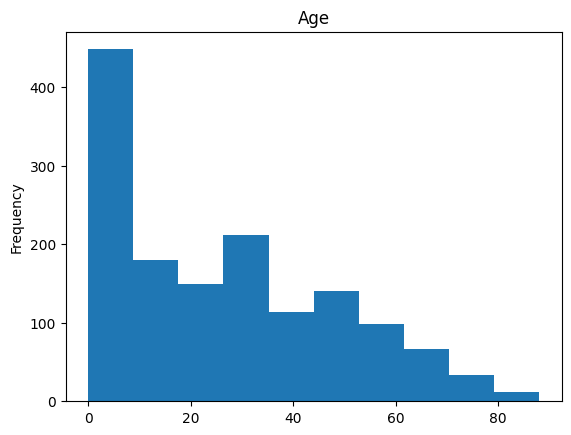

In [70]:
covid_flu['Age'].plot(title='Age', kind='hist')

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

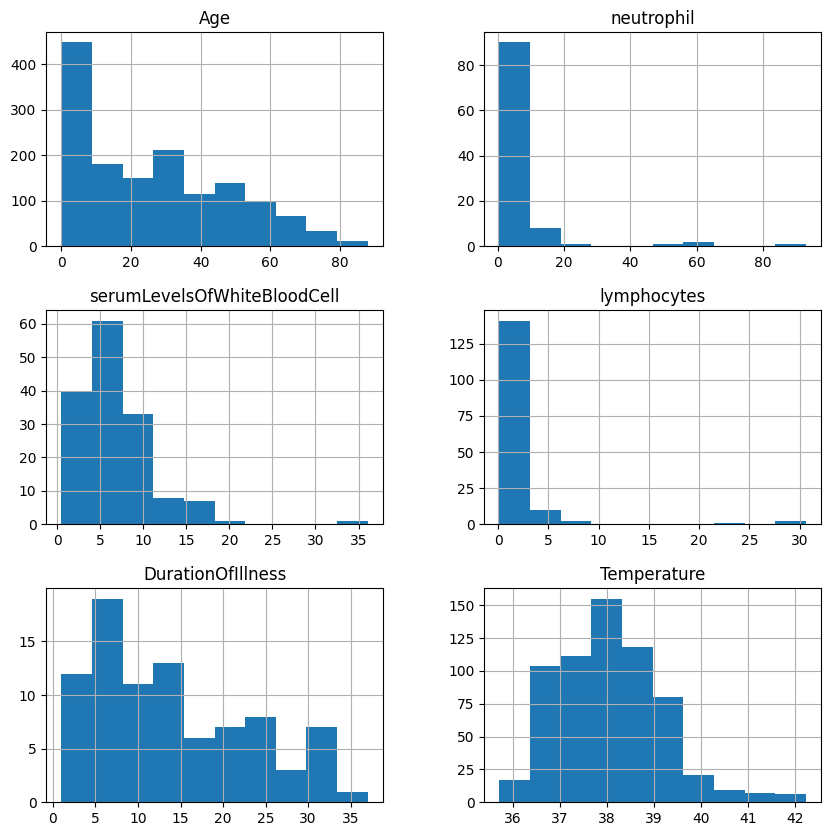

In [72]:
#pd.DataFrame(covid_flu[numerical_columns]).hist(figsize=(10, 10))
covid_flu[numerical_columns].hist(figsize=(10, 10))

In [75]:
covid_flu[numerical_columns].describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,26.471040,6.854078,6.885159,1.850154,13.988506,38.068312
std,21.487982,12.690131,4.346668,3.956668,9.043171,1.094468
min,0.000000,0.446000,0.500000,0.130000,1.000000,35.722222
25%,7.000000,2.160000,3.995000,0.637500,7.000000,37.222222
50%,24.000000,3.310000,5.690000,0.905500,12.000000,38.000000
75%,42.000000,6.645000,9.155000,1.605000,20.000000,38.722222
max,88.000000,93.000000,36.070000,30.600000,37.000000,42.222222


## Create custom data transformer !!!

In [76]:
# A custom data transformer to deal with our messy risk factor column

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer  # class to help make dummy variables
from functools import reduce

class DummifyRiskFactor(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.label_binarizer = None
        
    def parse_risk_factors(self, comma_sep_factors):
        ''' asthma,heart disease -> ['asthma', 'heart disease'] '''
        try:
            return [s.strip().lower() for s in comma_sep_factors.split(',')]
        except:
            return []
    
    def fit(self, X, y=None):
        self.label_binarizer = MultiLabelBinarizer()
        self.label_binarizer.fit(X.apply(self.parse_risk_factors))  # create dummy variable for each risk factor
        return self
    
    def transform(self, X, y=None):
        return self.label_binarizer.transform(X.apply(self.parse_risk_factors))

In [77]:
drf = DummifyRiskFactor()

risks = drf.fit_transform(covid_flu['RiskFactors'])

print(risks.shape)

pd.DataFrame(risks, columns=drf.label_binarizer.classes_) # convert narray dtype into dataFrame

(1482, 41)


,asthma,athero,atopic dermatitis and repetitive respiratory infections,begin tumor (removed),chronic,chronic endrocrine disorder,chronic liver dieseas,chronic liver disorder,chronic neurological disorders,chronic obstructive pulmonary disease,...,lung disease,myxoma of abdominal cavity,obesity,pneumomediastinum and subcutaneous emphysema,pneumonia,pre-eclampsia,prom,renal disease,respiratory disease,rheumatoid arthritis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


drf.label_binarizer.classes_

# Train/Test splits

In [83]:
from sklearn.model_selection import train_test_split

X, y = covid_flu.drop(['Diagnosis'], axis=1), covid_flu['Diagnosis']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, test_size=.2
)

In [85]:
y_train.value_counts(normalize=True)

Diagnosis
H1N1       0.723207
COVID19    0.276793
Name: proportion, dtype: float64

In [86]:
y_test.value_counts(normalize=True)

Diagnosis
H1N1       0.723906
COVID19    0.276094
Name: proportion, dtype: float64

In [92]:
x_train.head()

,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
978,NaN,5.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Yes,NaN,No,No,38.722222,Yes
1095,NaN,32.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,No,No,NaN,NaN,NaN
559,NaN,6.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
870,NaN,8.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,Yes,NaN,Yes,No,37.388889,Yes
1465,NaN,65.0,F,3.13,4.31,0.88,52.6,NaN,NaN,Heart Disease,NaN,No,Yes,Yes,NaN,NaN,Yes,NaN,NaN


# Create Pipeline !!

In [87]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# deal with risk factors

risk_factor_pipeline = Pipeline(
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor())
    ]
)

# deal with binary columns

binary_pipeline = Pipeline(
    [
        ('select_categorical_features', FunctionTransformer(lambda df: df[binary_features])),
        ('fillna', SimpleImputer(strategy='constant', fill_value=False))  # assume missing values are not present
    ]
)

# deal with numerical columns

numerical_pipeline = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('impute', SimpleImputer(strategy='median')),
    ]
)

# Notice the Pipeline's return value are of array dtype !!

In [96]:
risk_factor_pipeline.fit_transform(covid_flu)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1482, 41))

In [97]:
numerical_pipeline.fit_transform(covid_flu)

array([[67.        ,  3.31      ,  5.69      ,  0.9055    , 12.        ,
        38.11111111],
       [29.        ,  3.31      ,  5.69      ,  0.9055    , 12.        ,
        38.        ],
       [22.        ,  3.31      ,  5.69      ,  0.9055    , 12.        ,
        38.        ],
       ...,
       [ 3.        ,  3.31      , 15.        ,  0.9055    , 12.        ,
        38.        ],
       [ 4.        ,  3.31      ,  6.6       ,  0.9055    , 12.        ,
        38.        ],
       [ 6.        ,  3.31      ,  5.3       ,  0.9055    , 12.        ,
        38.        ]], shape=(1482, 6))

# Apply Grid Search !!

In [89]:
# only using numerical values has a good precision on COVID class but awful recall..
simple_grid_search(x_train, y_train, x_test, y_test, numerical_pipeline)

Parsing took 0.04 seconds
Training took 34.55 seconds
              precision    recall  f1-score   support

     COVID19       0.78      0.72      0.75        82
        H1N1       0.90      0.92      0.91       215

    accuracy                           0.87       297
   macro avg       0.84      0.82      0.83       297
weighted avg       0.86      0.87      0.86       297

Overall took 34.59 seconds


,n_estimators,50
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False
